## A. Configuración General.

In [1]:
#1. Librerías.
%run "./librerias.ipynb"

c:\Users\c678456\AppData\Local\anaconda3\envs\dmeyf\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#3. Constantes.
%run "./constantes.ipynb"

In [3]:
#4. Funciones
%run "./funciones.ipynb"

## B. Construcción de modelos.

#### 1. Modelo 1 -----> Datos v1 con -1 de Data Drifting sin ratios.

In [4]:
#a. Lectura de datos.
data_m1 = pd.read_csv(base_path + dataset_file_menos_1_v1) # Datos v1 con -1 de Data Drifting sin ratios.

In [5]:
#b. Arreglos previos para la data.
#i. Asignación de pesos.
data_m1['clase_peso'] = 1.0

data_m1.loc[data_m1['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
data_m1.loc[data_m1['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

#ii. Reajuste de las clases a predecir.
data_m1['clase_binaria1'] = 0
data_m1['clase_binaria2'] = 0
data_m1['clase_binaria1'] = np.where(data_m1['clase_ternaria'] == 'BAJA+2', 1, 0)
data_m1['clase_binaria2'] = np.where(data_m1['clase_ternaria'] == 'CONTINUA', 0, 1)

#iii. Filtramos para hacer backtesting.
train_data_m1 = data_m1[data_m1['foto_mes'] == mes_backtesting_train]
test_data_m1 = data_m1[data_m1['foto_mes'] == mes_backtesting_test]

X_train_m1 = train_data_m1.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_train_binaria1_m1 = train_data_m1['clase_binaria1']
y_train_binaria2_m1 = train_data_m1['clase_binaria2']
w_train_m1 = train_data_m1['clase_peso']

X_test_m1 = test_data_m1.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_test_binaria1_m1 = test_data_m1['clase_binaria1']
y_test_class_m1 = test_data_m1['clase_ternaria']
w_test_m1 = test_data_m1['clase_peso']

In [6]:
del data_m1

In [ ]:
#c. Optimización de hiperparámetros.
#i. Función.
def objective(trial):
    
    # Rango de parámetros a buscar sus valores óptimos.
    num_leaves = trial.suggest_int('num_leaves', 8, 100),
    learning_rate = trial.suggest_float('learning_rate', 0.005, 0.3), # mas bajo, más iteraciones necesita.
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 1, 1000),
    feature_fraction = trial.suggest_float('feature_fraction', 0.1, 1.0),
    bagging_fraction = trial.suggest_float('bagging_fraction', 0.1, 1.0),

    # Parámetros que le voy a pasar al modelo.
    params = {
        'objective': 'binary',
        'metric': 'custom',
        'boosting_type': 'gbdt',
        'first_metric_only': True,
        'boost_from_average': True,
        'feature_pre_filter': False,
        'max_bin': 31,
        'num_leaves': num_leaves,
        'learning_rate': learning_rate,
        'min_data_in_leaf': min_data_in_leaf,
        'feature_fraction': feature_fraction,
        'bagging_fraction': bagging_fraction,
        'seed': semillas[0],
        'verbose': -1
    }
    
    # Creo el dataset para Light GBM.
    train_data = lgb.Dataset(X_train_m1,
                              label=y_train_binaria2_m1, # eligir la clase
                              weight=w_train_m1)
    
    # Entreno.
    cv_results = lgb.cv(
        params,
        train_data,
        num_boost_round=100, # modificar, subit y subir... y descomentar la línea inferior
        # early_stopping_rounds= int(50 + 5 / learning_rate),
        feval=lgb_gan_eval,
        stratified=True,
        nfold=5,
        seed=semillas[0]
    )
    
    # Calculo la ganancia máxima y la mejor iteración donde se obtuvo dicha ganancia.
    max_gan = max(cv_results['valid gan_eval-mean'])
    best_iter = cv_results['valid gan_eval-mean'].index(max_gan) + 1

    # Guardamos cual es la mejor iteración del modelo
    trial.set_user_attr("best_iter", best_iter)

    return max_gan * 5


# Guardo el estudio de Optuna en una BBDD.
storage_name = "sqlite:///" + db_path + "optimization_lgbm.db"
study_name = "exp_backtesting_modelo1_lgbm"

study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

In [ ]:
#ii. Corremos.
study.optimize(objective, n_trials=50) # subir subir

In [ ]:
#d. Tomamos el mejor modelo y lo entrenamos con todos los datos de Train.
best_iter = study.best_trial.user_attrs["best_iter"]
print(f"Mejor cantidad de árboles para el mejor model {best_iter}")
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'first_metric_only': True,
    'boost_from_average': True,
    'feature_pre_filter': False,
    'max_bin': 31,
    'num_leaves': study.best_trial.params['num_leaves'],
    'learning_rate': study.best_trial.params['learning_rate'],
    'min_data_in_leaf': study.best_trial.params['min_data_in_leaf'],
    'feature_fraction': study.best_trial.params['feature_fraction'],
    'bagging_fraction': study.best_trial.params['bagging_fraction'],
    'seed': semillas[0],
    'verbose': 0
}

train_data_m1 = lgb.Dataset(X_train_m1,
                          label=y_train_binaria2_m1,
                          weight=w_train_m1)

modelo_1 = lgb.train(params,
                  train_data_m1,
                  num_boost_round=best_iter)


In [ ]:
#e. Guardamos el modelo.
modelo_1.save_model('./backtesting_modelo1.txt')

#### 2. Modelo 2 ----> Datos v1 sin Feature Engineering de ningún tipo.

In [7]:
#a. Lectura de datos.
data_m2 = pd.read_csv(base_path + dataset_file_crudo) # Datos v1 sin Feature Engineering de ningún tipo.

In [8]:
#b. Arreglos previos para la data.
#i. Asignación de pesos.
data_m2['clase_peso'] = 1.0

data_m2.loc[data_m2['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
data_m2.loc[data_m2['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

#ii. Reajuste de las clases a predecir.
data_m2['clase_binaria1'] = 0
data_m2['clase_binaria2'] = 0
data_m2['clase_binaria1'] = np.where(data_m2['clase_ternaria'] == 'BAJA+2', 1, 0)
data_m2['clase_binaria2'] = np.where(data_m2['clase_ternaria'] == 'CONTINUA', 0, 1)

#iii. Filtramos para hacer backtesting.
train_data_m2 = data_m2[data_m2['foto_mes'] == mes_backtesting_train]
test_data_m2 = data_m2[data_m2['foto_mes'] == mes_backtesting_test]

X_train_m2 = train_data_m2.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_train_binaria1_m2 = train_data_m2['clase_binaria1']
y_train_binaria2_m2 = train_data_m2['clase_binaria2']
w_train_m2 = train_data_m2['clase_peso']

X_test_m2 = test_data_m2.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_test_binaria1_m2 = test_data_m2['clase_binaria1']
y_test_class_m2 = test_data_m2['clase_ternaria']
w_test_m2 = test_data_m2['clase_peso']

In [9]:
del data_m2

In [ ]:
#c. Optimización de hiperparámetros.
#i. Función.
def objective(trial):
    
    # Rango de parámetros a buscar sus valores óptimos.
    num_leaves = trial.suggest_int('num_leaves', 8, 100),
    learning_rate = trial.suggest_float('learning_rate', 0.005, 0.3), # mas bajo, más iteraciones necesita.
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 1, 1000),
    feature_fraction = trial.suggest_float('feature_fraction', 0.1, 1.0),
    bagging_fraction = trial.suggest_float('bagging_fraction', 0.1, 1.0),

    # Parámetros que le voy a pasar al modelo.
    params = {
        'objective': 'binary',
        'metric': 'custom',
        'boosting_type': 'gbdt',
        'first_metric_only': True,
        'boost_from_average': True,
        'feature_pre_filter': False,
        'max_bin': 31,
        'num_leaves': num_leaves,
        'learning_rate': learning_rate,
        'min_data_in_leaf': min_data_in_leaf,
        'feature_fraction': feature_fraction,
        'bagging_fraction': bagging_fraction,
        'seed': semillas[0],
        'verbose': -1
    }
    
    # Creo el dataset para Light GBM.
    train_data = lgb.Dataset(X_train_m2,
                              label=y_train_binaria2_m2, # eligir la clase
                              weight=w_train_m2)
    
    # Entreno.
    cv_results = lgb.cv(
        params,
        train_data,
        num_boost_round=100, # modificar, subit y subir... y descomentar la línea inferior
        # early_stopping_rounds= int(50 + 5 / learning_rate),
        feval=lgb_gan_eval,
        stratified=True,
        nfold=5,
        seed=semillas[0]
    )
    
    # Calculo la ganancia máxima y la mejor iteración donde se obtuvo dicha ganancia.
    max_gan = max(cv_results['valid gan_eval-mean'])
    best_iter = cv_results['valid gan_eval-mean'].index(max_gan) + 1

    # Guardamos cual es la mejor iteración del modelo
    trial.set_user_attr("best_iter", best_iter)

    return max_gan * 5


# Guardo el estudio de Optuna en una BBDD.
storage_name = "sqlite:///" + db_path + "optimization_lgbm.db"
study_name = "exp_backtesting_modelo2_lgbm"

study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

In [ ]:
#ii. Corremos.
study.optimize(objective, n_trials=50) # subir subir

In [ ]:
plot_slice(study)

In [ ]:
#d. Tomamos el mejor modelo y lo entrenamos con todos los datos de Train.
best_iter = study.best_trial.user_attrs["best_iter"]
print(f"Mejor cantidad de árboles para el mejor model {best_iter}")
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'first_metric_only': True,
    'boost_from_average': True,
    'feature_pre_filter': False,
    'max_bin': 31,
    'num_leaves': study.best_trial.params['num_leaves'],
    'learning_rate': study.best_trial.params['learning_rate'],
    'min_data_in_leaf': study.best_trial.params['min_data_in_leaf'],
    'feature_fraction': study.best_trial.params['feature_fraction'],
    'bagging_fraction': study.best_trial.params['bagging_fraction'],
    'seed': semillas[0],
    'verbose': 0
}

train_data_m2 = lgb.Dataset(X_train_m2,
                          label=y_train_binaria2_m2,
                          weight=w_train_m2)

modelo_2 = lgb.train(params,
                  train_data_m2,
                  num_boost_round=best_iter)


In [ ]:
#e. Guardamos el modelo.
modelo_2.save_model('./backtesting_modelo2.txt')

#### 3. Modelo 3 ----> Datos v2 sin Feature Engineering de ningún tipo (solo pre-procesamiento).

In [10]:
#a. Lectura de datos.
data_m3 = pd.read_csv(base_path + dataset_file_preprocesado) # Datos v2 sin Feature Engineering de ningún tipo.

In [11]:
#b. Arreglos previos para la data.
#i. Asignación de pesos.
data_m3['clase_peso'] = 1.0

data_m3.loc[data_m3['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
data_m3.loc[data_m3['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

#ii. Reajuste de las clases a predecir.
data_m3['clase_binaria1'] = 0
data_m3['clase_binaria2'] = 0
data_m3['clase_binaria1'] = np.where(data_m3['clase_ternaria'] == 'BAJA+2', 1, 0)
data_m3['clase_binaria2'] = np.where(data_m3['clase_ternaria'] == 'CONTINUA', 0, 1)

#iii. Filtramos para hacer backtesting.
train_data_m3 = data_m3[data_m3['foto_mes'] == mes_backtesting_train]
test_data_m3 = data_m3[data_m3['foto_mes'] == mes_backtesting_test]

X_train_m3 = train_data_m3.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_train_binaria1_m3 = train_data_m3['clase_binaria1']
y_train_binaria2_m3 = train_data_m3['clase_binaria2']
w_train_m3 = train_data_m3['clase_peso']

X_test_m3 = test_data_m3.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_test_binaria1_m3 = test_data_m3['clase_binaria1']
y_test_class_m3 = test_data_m3['clase_ternaria']
w_test_m3 = test_data_m3['clase_peso']

In [12]:
del data_m3

In [ ]:
#c. Optimización de hiperparámetros.
#i. Función.
def objective(trial):
    
    # Rango de parámetros a buscar sus valores óptimos.
    num_leaves = trial.suggest_int('num_leaves', 8, 100),
    learning_rate = trial.suggest_float('learning_rate', 0.005, 0.3), # mas bajo, más iteraciones necesita.
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 1, 1000),
    feature_fraction = trial.suggest_float('feature_fraction', 0.1, 1.0),
    bagging_fraction = trial.suggest_float('bagging_fraction', 0.1, 1.0),

    # Parámetros que le voy a pasar al modelo.
    params = {
        'objective': 'binary',
        'metric': 'custom',
        'boosting_type': 'gbdt',
        'first_metric_only': True,
        'boost_from_average': True,
        'feature_pre_filter': False,
        'max_bin': 31,
        'num_leaves': num_leaves,
        'learning_rate': learning_rate,
        'min_data_in_leaf': min_data_in_leaf,
        'feature_fraction': feature_fraction,
        'bagging_fraction': bagging_fraction,
        'seed': semillas[0],
        'verbose': -1
    }
    
    # Creo el dataset para Light GBM.
    train_data = lgb.Dataset(X_train_m3,
                              label=y_train_binaria2_m3, # eligir la clase
                              weight=w_train_m3)
    
    # Entreno.
    cv_results = lgb.cv(
        params,
        train_data,
        num_boost_round=100, # modificar, subit y subir... y descomentar la línea inferior
        # early_stopping_rounds= int(50 + 5 / learning_rate),
        feval=lgb_gan_eval,
        stratified=True,
        nfold=5,
        seed=semillas[0]
    )
    
    # Calculo la ganancia máxima y la mejor iteración donde se obtuvo dicha ganancia.
    max_gan = max(cv_results['valid gan_eval-mean'])
    best_iter = cv_results['valid gan_eval-mean'].index(max_gan) + 1

    # Guardamos cual es la mejor iteración del modelo
    trial.set_user_attr("best_iter", best_iter)

    return max_gan * 5


# Guardo el estudio de Optuna en una BBDD.
storage_name = "sqlite:///" + db_path + "optimization_lgbm.db"
study_name = "exp_backtesting_modelo3_lgbm"

study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

In [ ]:
#ii. Corremos.
study.optimize(objective, n_trials=50) # subir subir

In [ ]:
plot_slice(study)

In [ ]:
#d. Tomamos el mejor modelo y lo entrenamos con todos los datos de Train.
best_iter = study.best_trial.user_attrs["best_iter"]
print(f"Mejor cantidad de árboles para el mejor model {best_iter}")
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'first_metric_only': True,
    'boost_from_average': True,
    'feature_pre_filter': False,
    'max_bin': 31,
    'num_leaves': study.best_trial.params['num_leaves'],
    'learning_rate': study.best_trial.params['learning_rate'],
    'min_data_in_leaf': study.best_trial.params['min_data_in_leaf'],
    'feature_fraction': study.best_trial.params['feature_fraction'],
    'bagging_fraction': study.best_trial.params['bagging_fraction'],
    'seed': semillas[0],
    'verbose': 0
}

train_data_m3 = lgb.Dataset(X_train_m3,
                          label=y_train_binaria2_m3,
                          weight=w_train_m3)

modelo_3 = lgb.train(params,
                  train_data_m3,
                  num_boost_round=best_iter)


In [ ]:
#e. Guardamos el modelo.
modelo_3.save_model('./backtesting_modelo3.txt')

#### 4. Modelo 4 -----> Datos v2 con -1 de Data Drifting (solo slope, sin ratios).

In [13]:
#a. Lectura de datos.
data_m4 = pd.read_csv(base_path + dataset_file_fe_menos_1_solo_slope) # Datos v2 con -1 de Data Drifting.

In [14]:
#b. Arreglos previos para la data.
#i. Asignación de pesos.
data_m4['clase_peso'] = 1.0

data_m4.loc[data_m4['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
data_m4.loc[data_m4['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

#ii. Reajuste de las clases a predecir.
data_m4['clase_binaria1'] = 0
data_m4['clase_binaria2'] = 0
data_m4['clase_binaria1'] = np.where(data_m4['clase_ternaria'] == 'BAJA+2', 1, 0)
data_m4['clase_binaria2'] = np.where(data_m4['clase_ternaria'] == 'CONTINUA', 0, 1)

#iii. Filtramos para hacer backtesting.
train_data_m4 = data_m4[data_m4['foto_mes'] == mes_backtesting_train]
test_data_m4= data_m4[data_m4['foto_mes'] == mes_backtesting_test]

X_train_m4 = train_data_m4.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_train_binaria1_m4 = train_data_m4['clase_binaria1']
y_train_binaria2_m4 = train_data_m4['clase_binaria2']
w_train_m4 = train_data_m4['clase_peso']

X_test_m4 = test_data_m4.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_test_binaria1_m4 = test_data_m4['clase_binaria1']
y_test_class_m4 = test_data_m4['clase_ternaria']
w_test_m4 = test_data_m4['clase_peso']

In [15]:
del data_m4

In [ ]:
#c. Optimización de hiperparámetros.
#i. Función.
def objective(trial):
    
    # Rango de parámetros a buscar sus valores óptimos.
    num_leaves = trial.suggest_int('num_leaves', 8, 200),
    learning_rate = trial.suggest_float('learning_rate', 0.005, 0.3), # mas bajo, más iteraciones necesita.
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 1, 1000),
    feature_fraction = trial.suggest_float('feature_fraction', 0.1, 1.0),
    bagging_fraction = trial.suggest_float('bagging_fraction', 0.1, 1.0),

    # Parámetros que le voy a pasar al modelo.
    params = {
        'objective': 'binary',
        'metric': 'custom',
        'boosting_type': 'gbdt',
        'first_metric_only': True,
        'boost_from_average': True,
        'feature_pre_filter': False,
        'max_bin': 31,
        'num_leaves': num_leaves,
        'learning_rate': learning_rate,
        'min_data_in_leaf': min_data_in_leaf,
        'feature_fraction': feature_fraction,
        'bagging_fraction': bagging_fraction,
        'seed': semillas[0],
        'verbose': -1
    }
    
    # Creo el dataset para Light GBM.
    train_data = lgb.Dataset(X_train_m4,
                              label=y_train_binaria2_m4, # eligir la clase
                              weight=w_train_m4)
    
    # Entreno.
    cv_results = lgb.cv(
        params,
        train_data,
        num_boost_round=100, # modificar, subit y subir... y descomentar la línea inferior
        # early_stopping_rounds= int(50 + 5 / learning_rate),
        feval=lgb_gan_eval,
        stratified=True,
        nfold=5,
        seed=semillas[0]
    )
    
    # Calculo la ganancia máxima y la mejor iteración donde se obtuvo dicha ganancia.
    max_gan = max(cv_results['valid gan_eval-mean'])
    best_iter = cv_results['valid gan_eval-mean'].index(max_gan) + 1

    # Guardamos cual es la mejor iteración del modelo
    trial.set_user_attr("best_iter", best_iter)

    return max_gan * 5


# Guardo el estudio de Optuna en una BBDD.
storage_name = "sqlite:///" + db_path + "optimization_lgbm.db"
study_name = "exp_backtesting_modelo4_lgbm"

study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

In [ ]:
#ii. Corremos.
study.optimize(objective, n_trials=10) # subir subir

In [ ]:
plot_slice(study)

In [ ]:
#d. Tomamos el mejor modelo y lo entrenamos con todos los datos de Train.
best_iter = study.best_trial.user_attrs["best_iter"]
print(f"Mejor cantidad de árboles para el mejor model {best_iter}")
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'first_metric_only': True,
    'boost_from_average': True,
    'feature_pre_filter': False,
    'max_bin': 31,
    'num_leaves': study.best_trial.params['num_leaves'],
    'learning_rate': study.best_trial.params['learning_rate'],
    'min_data_in_leaf': study.best_trial.params['min_data_in_leaf'],
    'feature_fraction': study.best_trial.params['feature_fraction'],
    'bagging_fraction': study.best_trial.params['bagging_fraction'],
    'seed': semillas[0],
    'verbose': 0
}

train_data_m4 = lgb.Dataset(X_train_m4,
                          label=y_train_binaria2_m4,
                          weight=w_train_m4)

modelo_4 = lgb.train(params,
                  train_data_m4,
                  num_boost_round=best_iter)


In [ ]:
#e. Guardamos el modelo.
modelo_4.save_model('./backtesting_modelo4.txt')

## C. Comparación entre modelos.

In [16]:
#1. Leo mis modelos.
print("Empieza el Modelo 1...")
modelo_1 = lgb.Booster(model_file='./backtesting_modelo1.txt')
print("Empieza el Modelo 2...")
modelo_2 = lgb.Booster(model_file='./backtesting_modelo2.txt')
print("Empieza el Modelo 3...")
modelo_3 = lgb.Booster(model_file='./backtesting_modelo3.txt')
print("Empieza el Modelo 4...")
modelo_4 = lgb.Booster(model_file='./backtesting_modelo4.txt')

Empieza el Modelo 1...
Empieza el Modelo 2...
Empieza el Modelo 3...
Empieza el Modelo 4...


In [17]:
#2. Predigo con la información de Febrero, Abril.
print("Empieza el Modelo 1...")
y_pred_m1 = modelo_1.predict(X_test_m1)
print("Empieza el Modelo 2...")
y_pred_m2 = modelo_2.predict(X_test_m2)
print("Empieza el Modelo 3...")
y_pred_m3 = modelo_3.predict(X_test_m3)
print("Empieza el Modelo 4...")
y_pred_m4 = modelo_4.predict(X_test_m4)

Empieza el Modelo 1...
Empieza el Modelo 2...
Empieza el Modelo 3...
Empieza el Modelo 4...


In [18]:
#3. Medimos las ganancias de los modelos.
def ganancia_prob(y_pred, y_true, prop = 1):
  ganancia = np.where(y_true == 1, ganancia_acierto, 0) - np.where(y_true == 0, costo_estimulo, 0)
  return ganancia[y_pred >= 0.025].sum() / prop

print("Ganancia M1:", ganancia_prob(y_pred_m1, y_test_binaria1_m1))
print("Ganancia M2:", ganancia_prob(y_pred_m2, y_test_binaria1_m2))
print("Ganancia M3:", ganancia_prob(y_pred_m3, y_test_binaria1_m3))
print("Ganancia M4:", ganancia_prob(y_pred_m4, y_test_binaria1_m4))

Ganancia M1: 144641000.0
Ganancia M2: 140980000.0
Ganancia M3: 143402000.0
Ganancia M4: 144963000.0


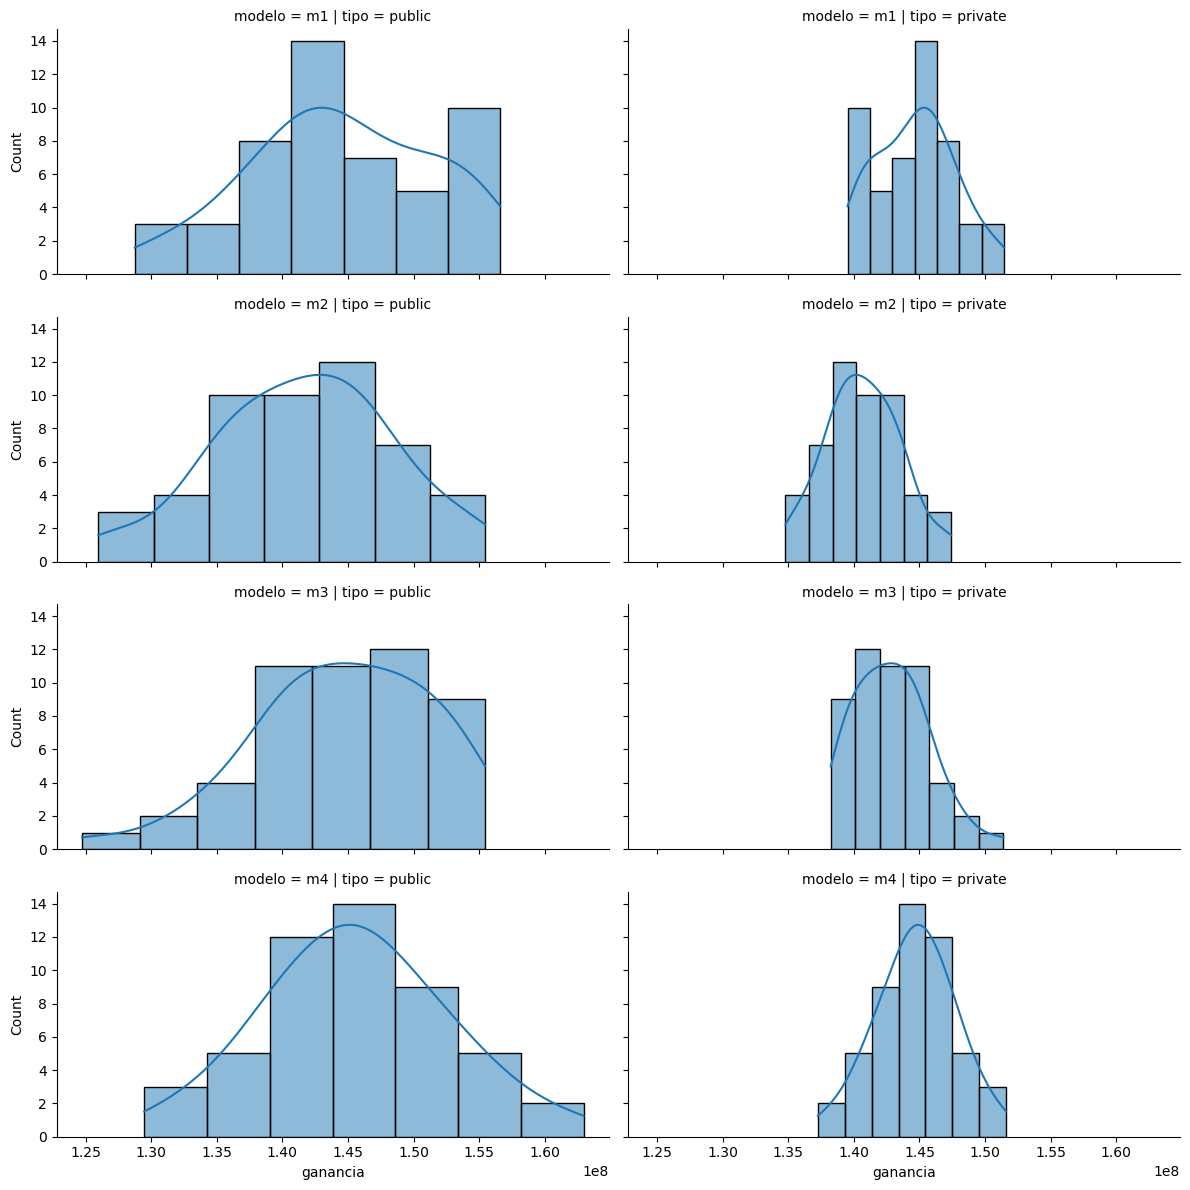

In [19]:
#4. ¿Y si hacemos distintas divisiones entre Público y Privado?
#i. Estratificamos 50 escenarios distintos.
sss_futuro = StratifiedShuffleSplit(n_splits=50,
                                    test_size=0.3,
                                    random_state=semillas[0])

#ii. Definimos los modelos y sus respectivos X_test y y_test.
modelos = {
    "m1": {"pred": y_pred_m1, "X_test": X_test_m1, "y_test": y_test_binaria1_m1},
    "m2": {"pred": y_pred_m2, "X_test": X_test_m2, "y_test": y_test_binaria1_m2},
    "m3": {"pred": y_pred_m3, "X_test": X_test_m3, "y_test": y_test_binaria1_m3},
    "m4": {"pred": y_pred_m4, "X_test": X_test_m4, "y_test": y_test_binaria1_m4}
}

rows = []

#iii. Para cada modelo, aplicamos StratifiedShuffleSplit.
for name, data in modelos.items():
    X_test = data["X_test"]
    y_test = data["y_test"]
    y_pred = data["pred"]
    
    for private_index, public_index in sss_futuro.split(X_test, y_test):
        row = {}
        # Calculamos la ganancia en la división pública y privada.
        row[name + "_public"] = ganancia_prob(y_pred[public_index], y_test.iloc[public_index], 0.3)
        row[name + "_private"] = ganancia_prob(y_pred[private_index], y_test.iloc[private_index], 0.7)
        rows.append(row)

#iv. Convertimos a DataFrame.
df_lb = pd.DataFrame(rows)

#v. Transformación a formato largo para visualización.
df_lb_long = df_lb.reset_index()
df_lb_long = df_lb_long.melt(id_vars=['index'], var_name='model_type', value_name='ganancia')
df_lb_long[['modelo', 'tipo']] = df_lb_long['model_type'].str.split('_', expand=True)
df_lb_long = df_lb_long[['ganancia', 'tipo', 'modelo']]

#vi. Visualización con seaborn.
g = sns.FacetGrid(df_lb_long, col="tipo", row="modelo", aspect=2)
g.map(sns.histplot, "ganancia", kde=True)
plt.show()

In [ ]:
#4. ¿Que pasa si hubiesemos elegido el mejor público en todos los casos?,¿Se replicaba en el Privado?
#i. Creamos un DataFrame que contenga las mejores ganancias públicas y privadas.
#df = pd.DataFrame()

#ii. Seleccionamos el modelo que tiene la mayor ganancia pública en cada fila.
#df['best_public'] = df_lb.filter(regex='_public').idxmax(axis=1)

#iii. Seleccionamos el modelo que tiene la mayor ganancia privada en cada fila.
#df['best_private'] = df_lb.filter(regex='_private').idxmax(axis=1)

#iv. Creamos la Tabla cruzada para ver la relación entre las mejores selecciones públicas y privadas.
#pd.crosstab(df['best_public'], df['best_private'])




# NO PUEDO HACER ESTE ANÁLISIS YA QUE LA INFORMACIÓN ES DISTINTA PARA CADA DATASET.

In [20]:
#5. Entender como se hubiese comportado el Público y Privado a partir de distintos puntos de corte de cantidad de envíos.
#i. Función.
def analisis_comportamiento_kaggle_completo(semilla, desde, paso, cantidad, private = False,ganancia = None,y_pred = None, y_etiqueta = None):

  df_cut_point = pd.DataFrame({'ganancia': ganancia, 'y_pred_lgm': y_pred})
  df_cut_point['nro_envios'] = df_cut_point.reset_index().index

  plt.figure(figsize=(10, 6))

  private_idx, public_idx = train_test_split(df_cut_point.index, test_size=0.3, random_state=semilla, stratify=y_etiqueta)

  df_cut_point['public'] = 0.0
  df_cut_point.loc[public_idx, 'public'] = ganancia[public_idx] / 0.3
  df_cut_point['public_cum'] = df_cut_point['public'].cumsum()

  maximo_paso = desde + paso*cantidad
  plt.plot(df_cut_point['nro_envios'][list(range(desde, maximo_paso + 1, paso))], df_cut_point['public_cum'][list(range(desde, maximo_paso + 1, paso))], label='Ganancia Pública Acumulada')
  max_public_cum = df_cut_point['public_cum'][list(range(desde, maximo_paso + 1, paso))].max()
  max_public_idx = df_cut_point['public_cum'][list(range(desde, maximo_paso + 1, paso))].idxmax()
  plt.axvline(x=max_public_idx, color='g', linestyle='--', label=f'Máximo Ganancia Pública en {max_public_idx}')

  if private:
    df_cut_point['private'] = 0.0
    df_cut_point.loc[private_idx, 'private'] = ganancia[private_idx] / 0.7
    df_cut_point['private_cum'] = df_cut_point['private'].cumsum()
    plt.plot(df_cut_point['nro_envios'][4000:20000], df_cut_point['private_cum'][4000:20000], label='Ganancia Privada Acumulada')
    max_private_cum = df_cut_point['private_cum'][4000:20000].max()
    max_private_idx = df_cut_point['private_cum'][4000:20000].idxmax()
    plt.axvline(x=max_private_idx, color='r', linestyle='--', label=f'Máximo Ganancia Privada en {max_private_idx}')

  plt.title('Curva de Ganancia Pública y Privada')
  plt.xlabel('Número de envíos')
  plt.ylabel('Ganancia Acumulada')
  plt.legend()
  plt.show()

In [21]:
#ii. Calculo de ganancia acumulada.
#a. Modelo 1.
ganancia_m1 = np.where(y_test_binaria1_m1 == 1, ganancia_acierto, 0) - np.where(y_test_binaria1_m1 == 0, costo_estimulo, 0)

idx_m1 = np.argsort(y_pred_m1)[::-1]

ganancia_m1 = ganancia_m1[idx_m1]
y_pred_m1 = y_pred_m1[idx_m1]

ganancia_cum_m1 = np.cumsum(ganancia_m1)

#b. Modelo 2.
ganancia_m2 = np.where(y_test_binaria1_m2 == 1, ganancia_acierto, 0) - np.where(y_test_binaria1_m2 == 0, costo_estimulo, 0)

idx_m2 = np.argsort(y_pred_m2)[::-1]

ganancia_m2 = ganancia_m2[idx_m2]
y_pred_m2 = y_pred_m2[idx_m2]

ganancia_cum_m2 = np.cumsum(ganancia_m2)

#c. Modelo 3.
ganancia_m3 = np.where(y_test_binaria1_m3 == 1, ganancia_acierto, 0) - np.where(y_test_binaria1_m3 == 0, costo_estimulo, 0)

idx_m3 = np.argsort(y_pred_m3)[::-1]

ganancia_m3 = ganancia_m3[idx_m3]
y_pred_m3 = y_pred_m3[idx_m3]

ganancia_cum_m3 = np.cumsum(ganancia_m3)

#d. Modelo 4.
ganancia_m4 = np.where(y_test_binaria1_m4 == 1, ganancia_acierto, 0) - np.where(y_test_binaria1_m4 == 0, costo_estimulo, 0)

idx_m4 = np.argsort(y_pred_m4)[::-1]

ganancia_m4 = ganancia_m4[idx_m4]
y_pred_m4 = y_pred_m4[idx_m4]

ganancia_cum_m4 = np.cumsum(ganancia_m4)

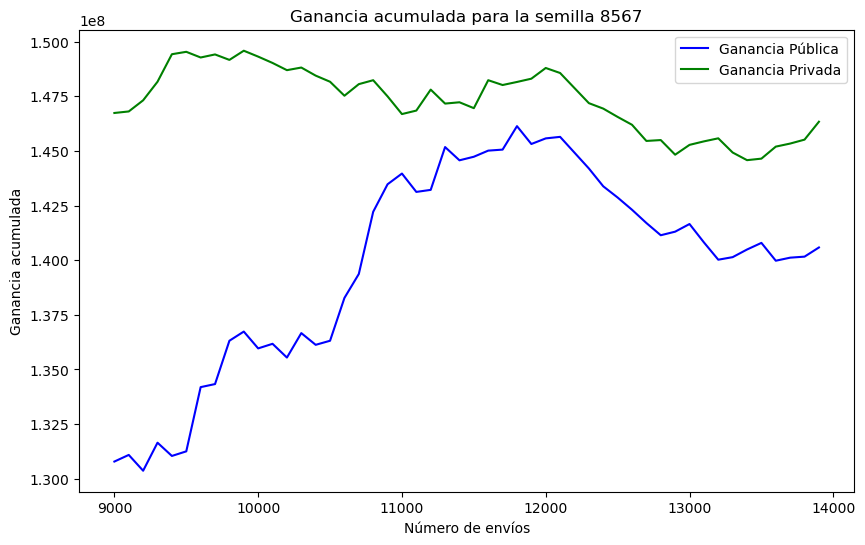

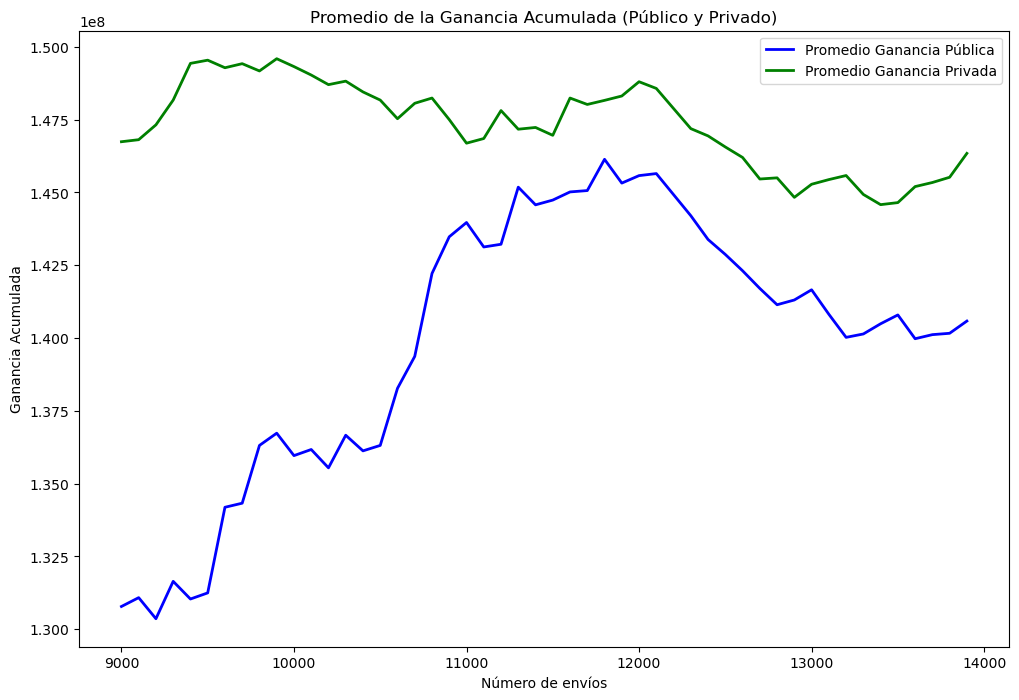

In [36]:
#ii. Ejecución para el modelo 1.
analisis_comportamiento_kaggle_completo(semillas[0],9000,100,50,private=True,ganancia=ganancia_m1,y_pred=y_pred_m1,y_etiqueta=y_test_binaria1_m1)

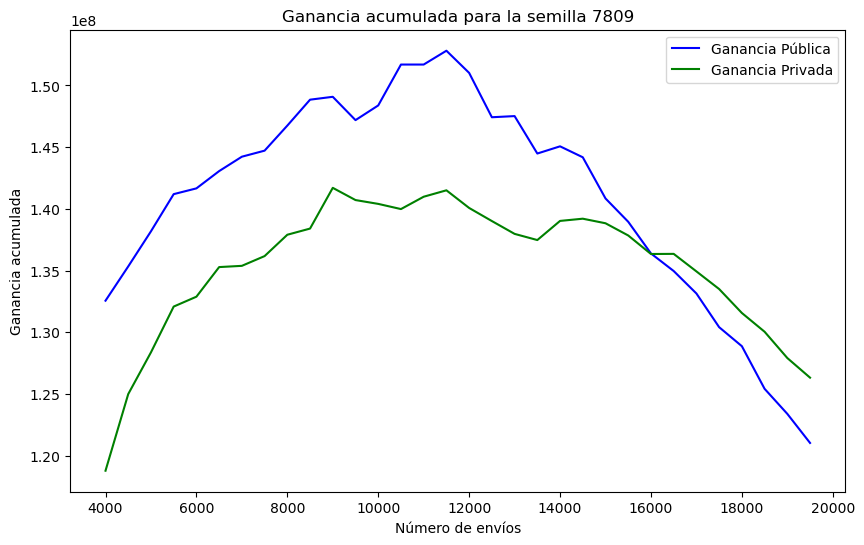

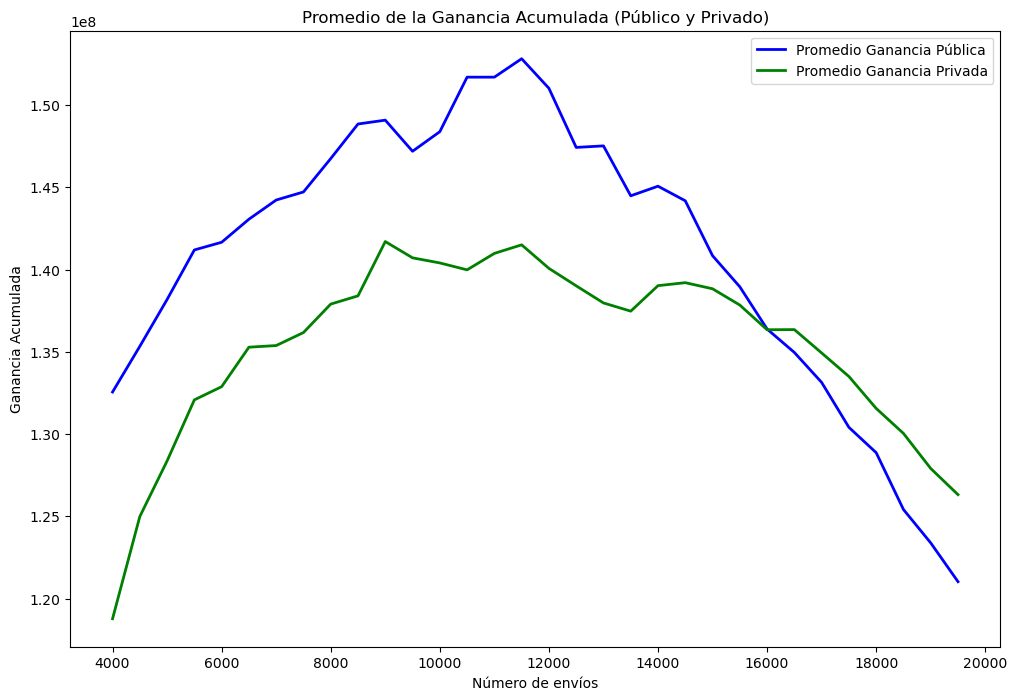

In [37]:
#iii. Ejecución para el modelo 2.
analisis_comportamiento_kaggle_completo(semillas[0],4000,500,32,private=True,ganancia=ganancia_m2,y_pred=y_pred_m2,y_etiqueta=y_test_binaria1_m2)

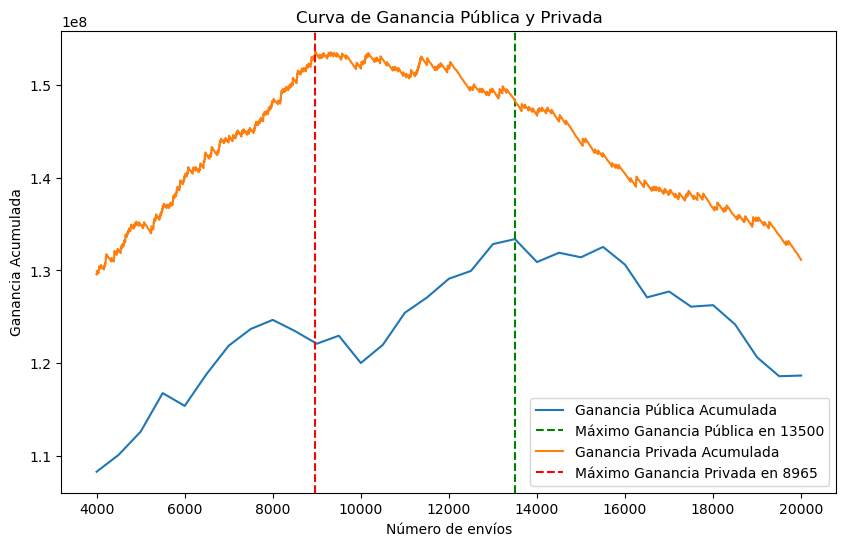

In [24]:
#iv. Ejecución para el modelo 3.
analisis_comportamiento_kaggle_completo(semillas[0],4000,500,32,private=True,ganancia=ganancia_m3,y_pred=y_pred_m3,y_etiqueta=y_test_binaria1_m3)

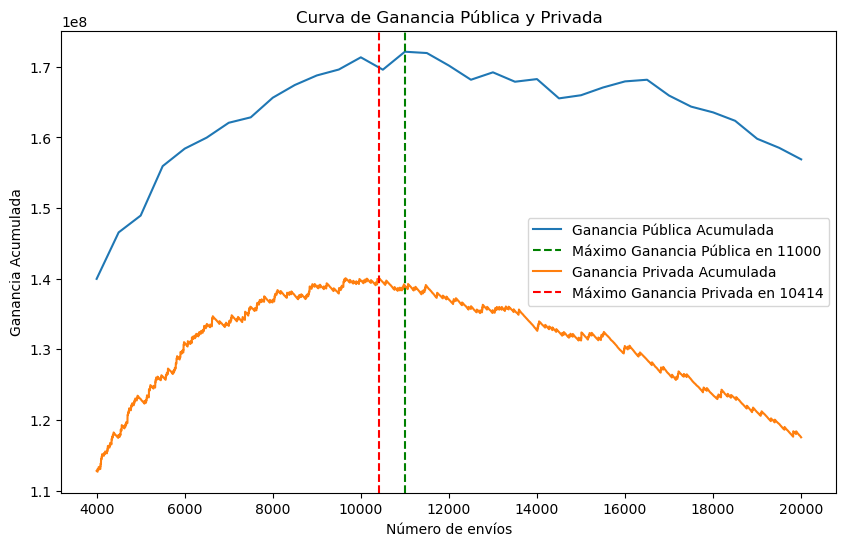

In [25]:
#v. Ejecución para el modelo 4.
analisis_comportamiento_kaggle_completo(semillas[0],4000,500,32,private=True,ganancia=ganancia_m4,y_pred=y_pred_m4,y_etiqueta=y_test_binaria1_m4)

#### Comportamiento general de las curvas públicas y privadas.

In [27]:
# Función para graficar las curvas públicas y privadas con líneas verticales en los puntos de ganancia máxima
def graficar_curvas_publicas_y_privadas(semillas, desde, paso, cantidad, ganancia, y_pred, y_etiqueta):
    plt.figure(figsize=(12, 8))
    
    max_public = []
    max_private = []
    
    # Colores para las curvas
    color_publico = 'yellow'  # Todas las curvas de público serán de color amarillo.
    color_privado = 'red'     # Todas las curvas de privado serán de color rojo.
    
    # Bucle sobre cada semilla
    for semilla in semillas:
        # Creo un DataFrame para almacenar resultados temporales.
        df_cut_point = pd.DataFrame({'ganancia': ganancia, 'y_pred_lgm': y_pred})
        df_cut_point['nro_envios'] = df_cut_point.reset_index().index

        # Divido entre público y privado.
        private_idx, public_idx = train_test_split(df_cut_point.index, test_size=0.3, random_state=semilla, stratify=y_etiqueta)

        # Ganancia acumulada pública.
        df_cut_point['public'] = 0.0
        df_cut_point.loc[public_idx, 'public'] = ganancia[public_idx] / 0.3
        df_cut_point['public_cum'] = df_cut_point['public'].cumsum()

        # Ganancia acumulada privada.
        df_cut_point['private'] = 0.0
        df_cut_point.loc[private_idx, 'private'] = ganancia[private_idx] / 0.7
        df_cut_point['private_cum'] = df_cut_point['private'].cumsum()

        # Extraigo las ganancias públicas y privadas en los puntos de corte.
        public_cum_range = df_cut_point['public_cum'][list(range(desde, desde + paso * cantidad, paso))]
        private_cum_range = df_cut_point['private_cum'][list(range(desde, desde + paso * cantidad, paso))]

        # Grafico las curvas de público y privado para esta semilla.
        plt.plot(list(range(desde, desde + paso * cantidad, paso)), public_cum_range, color=color_publico, alpha=0.5)
        plt.plot(list(range(desde, desde + paso * cantidad, paso)), private_cum_range, color=color_privado, alpha=0.5)

        # Agrego una recta vertical punteada en el valor máximo de la curva de público.
        max_public_idx = np.argmax(public_cum_range)
        plt.axvline(x=desde + max_public_idx * paso, color=color_publico, linestyle='--', alpha=0.5)
        max_public.append(desde + max_public_idx * paso)

        # Agrego una recta vertical punteada en el valor máximo de la curva de privado.
        max_private_idx = np.argmax(private_cum_range)
        plt.axvline(x=desde + max_private_idx * paso, color=color_privado, linestyle='--', alpha=0.5)
        max_private.append(desde + max_private_idx * paso)

    # Configuración del gráfico
    plt.title('Curvas de Ganancia Pública y Privada para Varias Semillas')
    plt.xlabel('Número de envíos')
    plt.ylabel('Ganancia acumulada')
    
    # Leyenda
    plt.plot([], [], color=color_publico, label='Ganancia Pública')  # Añadir solo para la leyenda
    plt.plot([], [], color=color_privado, label='Ganancia Privada')  # Añadir solo para la leyenda
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    print("Score Público:")
    print("Ganancias máximas para cada semilla: {}".format(max_public))
    print("\nPromedio: {}".format(np.mean(max_public)))
    print("Valor Máximo: {}".format(max(max_public)))
    print("Valor Mínimo: {}".format(min(max_public)))
    print("--------------------------------------------------------------")
    print("Score Privado:")
    print("Ganancias máximas para cada semilla: {}".format(max_private))
    print("\nPromedio: {}".format(np.mean(max_private)))
    print("Valor Máximo: {}".format(max(max_private)))
    print("Valor Mínimo: {}".format(min(max_private)))

c:\Users\c678456\AppData\Local\anaconda3\envs\dmeyf\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


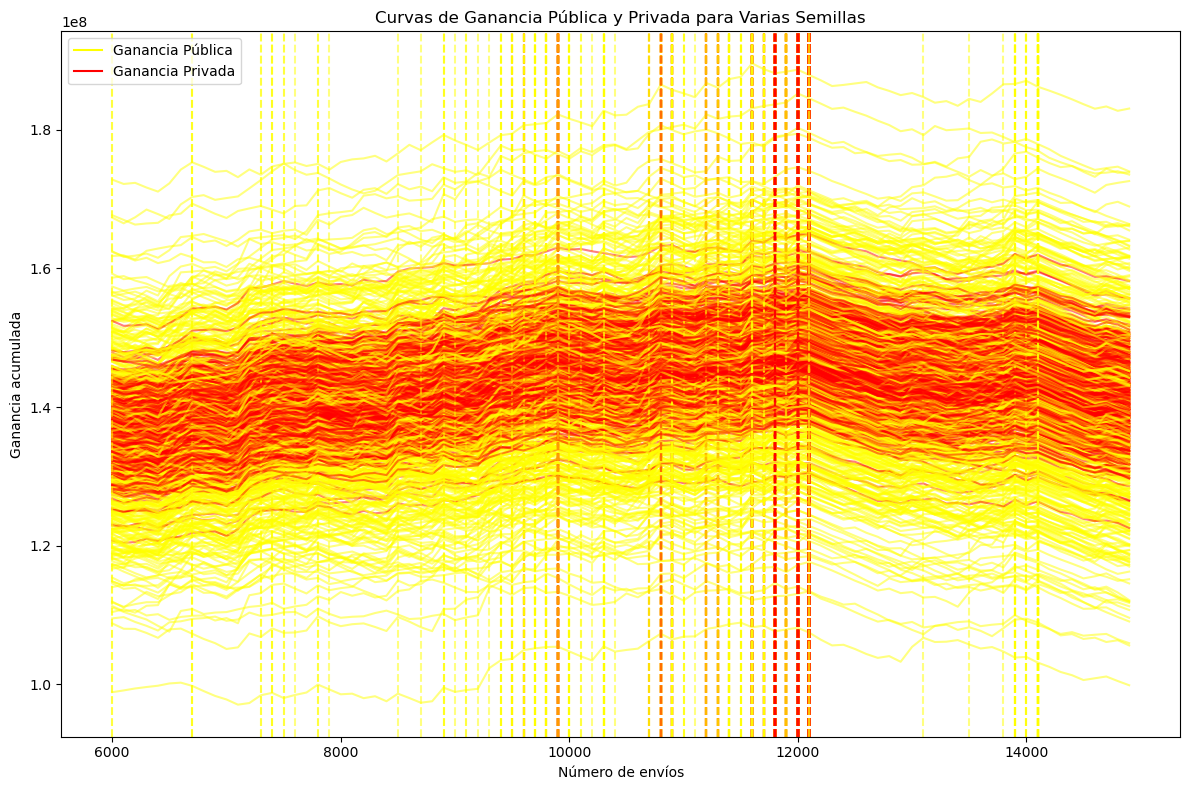

Score Público:
Ganancias máximas para cada semilla: [9900, 11400, 11800, 9900, 11800, 10800, 12100, 12100, 12000, 11700, 11700, 12000, 12100, 11600, 11800, 7800, 11300, 12000, 12100, 10800, 9600, 11800, 10200, 10800, 11800, 9800, 11800, 11600, 10800, 14100, 9900, 12000, 14100, 11900, 7900, 11600, 10300, 14100, 12100, 9700, 11800, 11800, 9500, 12000, 12000, 12000, 10000, 12000, 11500, 12000, 10800, 12100, 12000, 11900, 12100, 12100, 11800, 11900, 11900, 12000, 9900, 10800, 11800, 10700, 7400, 10800, 11600, 12000, 11900, 12000, 11400, 11300, 10900, 12000, 12000, 14100, 11500, 11900, 10800, 12100, 9600, 12100, 12100, 10700, 6000, 8900, 11700, 11300, 12100, 11700, 11900, 11400, 12100, 12100, 12100, 11600, 12100, 12000, 11900, 12100, 14100, 12100, 12000, 12000, 8500, 11600, 14100, 9400, 14100, 11900, 9900, 12100, 7400, 11300, 11600, 11800, 12000, 9400, 10000, 14100, 11900, 12000, 9700, 11800, 11900, 10800, 12000, 11700, 9900, 14100, 13900, 11900, 12100, 11400, 9900, 14100, 12000, 9300, 1210

In [126]:
#ii. Ejecución.
# Lista de semillas.
cantidad_semillas = 500
semillas = [np.random.randint(0, 10000) for _ in range(cantidad_semillas)]

# Función para graficar las curvas públicas y privadas de todas las semillas.
graficar_curvas_publicas_y_privadas(
    semillas=semillas,
    desde=6000,
    paso=100,
    cantidad=90,
    ganancia=ganancia_m1,     
    y_pred=y_pred_m1,         
    y_etiqueta=y_test_binaria1_m1  
)

In [ ]:
#iii. Observaciones.
# La forma de distribución del Score Privado se mantiene, más allá de cual sea la semilla. 
# Lo que cambia es su desplazamiento hacia arriba/abajo.

# La forma de distribución del Score Público cambia un poco más.
# Además, cambia su desplazamiento hacia arriba/abajo en un rango más amplio.

# El punto máximo en el Privado suele estar muy concentrado en 12.000.
# El punto máximo en el Público varía un poco más alrededor de 12.000.

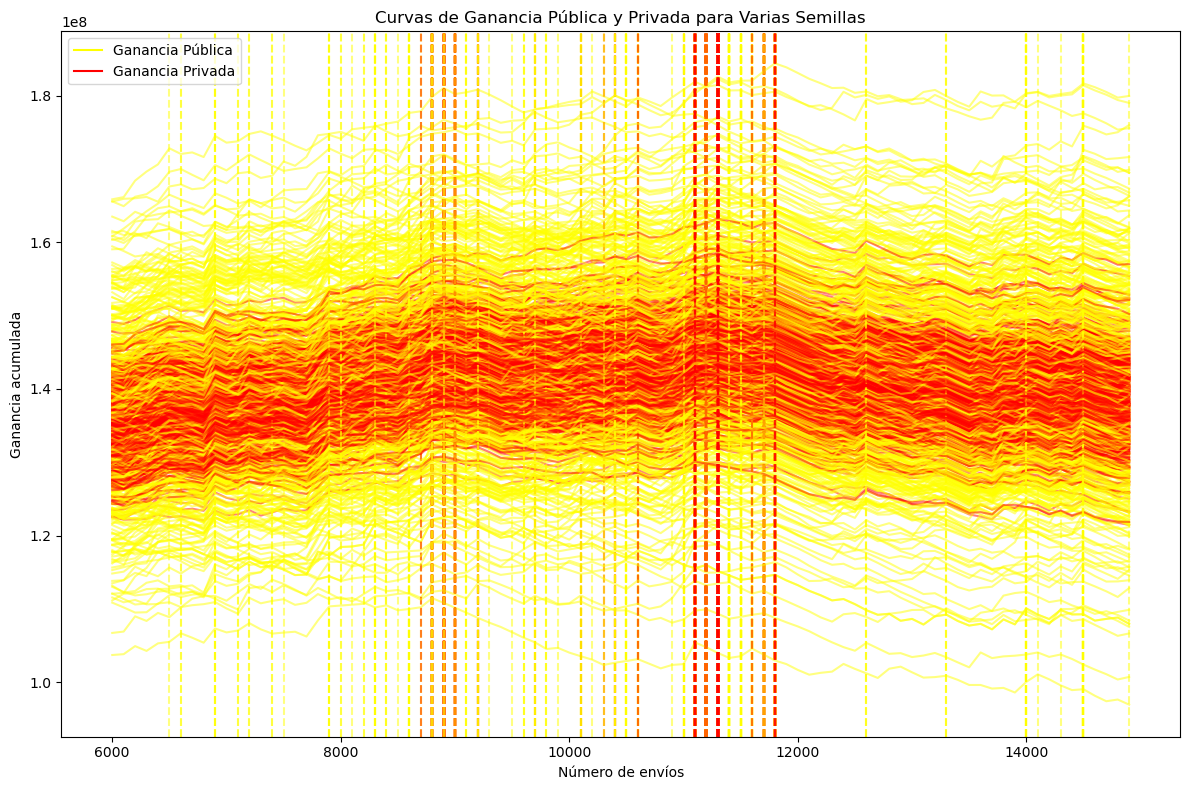

Score Público:
Ganancias máximas para cada semilla: [11200, 11300, 8500, 11300, 11200, 11300, 11300, 13300, 14500, 11300, 11800, 10100, 9800, 11200, 11800, 14000, 10100, 8900, 9000, 11200, 14500, 8800, 11100, 10500, 11300, 8800, 10400, 8800, 8900, 11700, 11400, 10900, 11300, 11600, 8900, 8900, 11600, 11200, 11800, 10600, 9700, 11400, 9700, 11400, 11200, 11100, 8800, 11200, 8700, 11500, 8700, 11300, 14500, 11100, 11500, 14100, 14300, 11800, 11200, 11000, 8800, 11100, 10100, 11100, 11500, 11800, 11100, 11500, 11100, 11300, 10500, 9000, 7100, 8800, 6600, 11300, 11800, 11800, 8800, 11800, 6500, 8800, 11200, 10100, 10500, 11800, 8800, 11000, 8600, 9100, 8800, 11700, 9500, 10600, 11400, 11100, 8400, 11400, 11100, 11200, 11800, 9000, 11500, 11700, 10600, 11100, 11300, 9100, 11300, 8900, 11300, 11400, 14500, 9000, 11700, 11100, 10600, 10200, 14000, 7100, 11200, 8800, 10100, 11100, 11200, 8600, 8300, 8900, 11400, 11600, 14000, 9000, 11100, 6900, 14000, 6900, 10400, 11200, 11600, 11200, 14000, 1

In [28]:
#ii. Ejecución.
# Lista de semillas.
cantidad_semillas = 500
semillas = [np.random.randint(0, 10000) for _ in range(cantidad_semillas)]

# Función para graficar las curvas públicas y privadas de todas las semillas.
graficar_curvas_publicas_y_privadas(
    semillas=semillas,
    desde=6000,
    paso=100,
    cantidad=90,
    ganancia=ganancia_m2,     
    y_pred=y_pred_m2,         
    y_etiqueta=y_test_binaria1_m2  
)

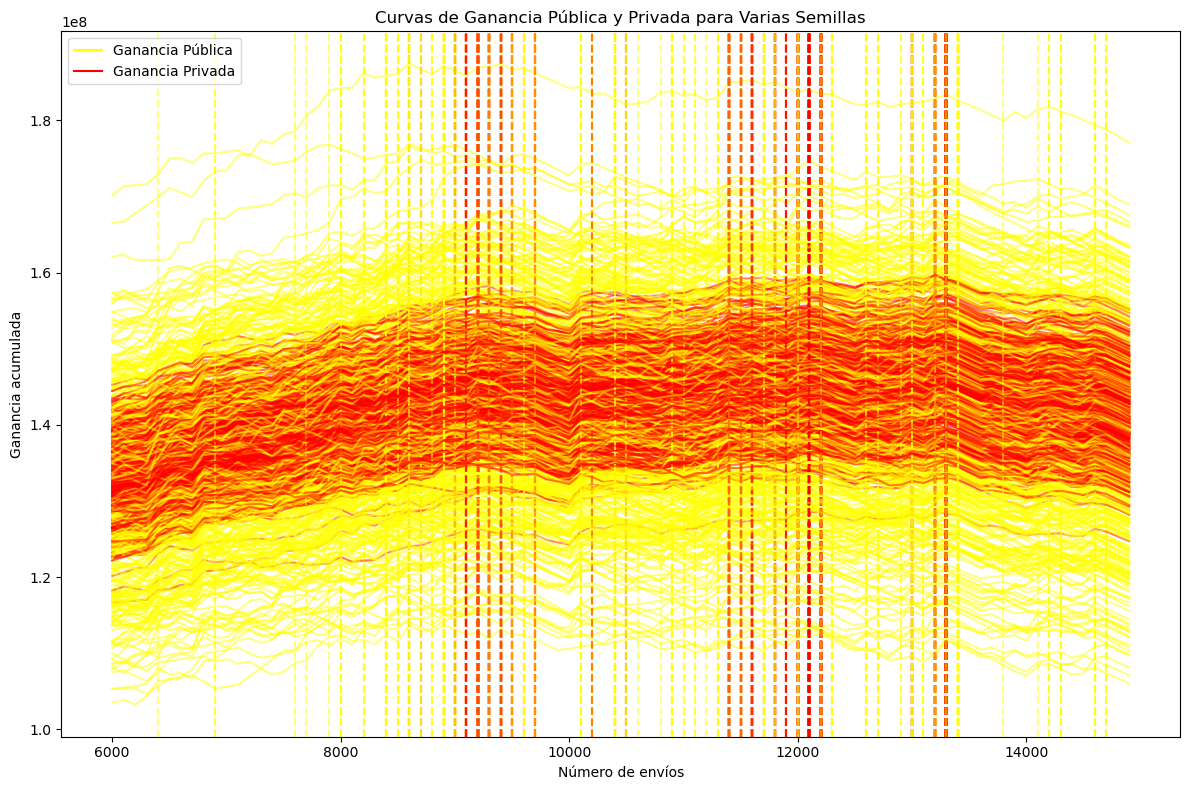

Score Público:
Ganancias máximas para cada semilla: [13200, 12000, 8400, 13300, 8600, 9200, 11400, 11600, 10100, 12000, 13400, 13300, 9500, 10900, 8200, 13300, 10600, 12200, 9200, 13000, 9200, 12100, 9300, 12200, 11400, 8600, 9400, 13300, 9100, 11400, 8600, 13400, 13300, 12200, 13200, 13300, 9300, 10200, 13400, 14700, 13300, 8900, 9600, 12300, 13300, 10100, 13400, 11200, 11800, 12300, 13300, 12000, 12200, 12100, 9000, 8900, 13300, 10200, 9200, 12200, 8600, 9000, 13300, 8200, 13400, 12100, 13300, 13300, 11500, 12200, 9400, 13300, 11500, 8900, 12300, 9300, 9400, 8600, 13400, 8000, 11800, 12100, 11700, 13200, 11900, 8400, 8900, 11800, 11400, 8600, 13000, 10200, 12100, 8900, 9000, 13300, 9200, 13400, 8600, 13300, 12100, 12200, 6400, 9000, 13400, 11400, 9200, 11400, 8900, 12100, 9400, 11500, 12100, 11500, 10100, 11600, 12000, 10100, 11500, 13200, 12100, 14300, 11500, 12900, 10800, 10400, 9000, 12100, 12200, 8900, 9300, 10900, 8600, 12200, 13300, 8900, 10200, 12300, 14600, 12200, 13100, 9600

In [29]:
#ii. Ejecución.
# Lista de semillas.
cantidad_semillas = 500
semillas = [np.random.randint(0, 10000) for _ in range(cantidad_semillas)]

# Función para graficar las curvas públicas y privadas de todas las semillas.
graficar_curvas_publicas_y_privadas(
    semillas=semillas,
    desde=6000,
    paso=100,
    cantidad=90,
    ganancia=ganancia_m3,     
    y_pred=y_pred_m3,         
    y_etiqueta=y_test_binaria1_m3  
)

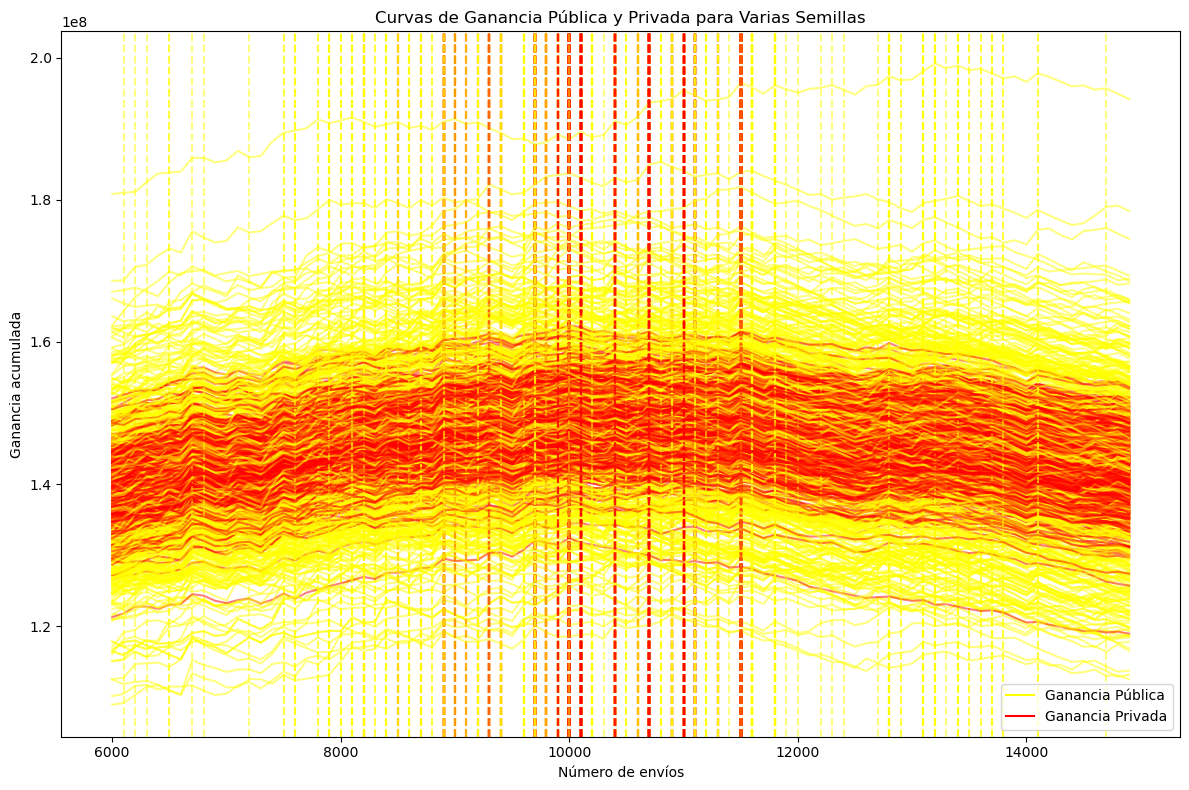

Score Público:
Ganancias máximas para cada semilla: [10700, 8900, 11600, 12400, 11000, 10400, 9700, 10400, 12700, 10000, 10700, 11500, 8300, 9900, 9100, 10000, 10600, 10400, 10900, 12800, 13100, 11500, 11500, 11000, 11000, 11500, 9700, 11000, 9700, 10900, 8900, 10100, 11000, 10000, 10900, 10100, 9800, 11000, 11100, 9700, 10600, 8900, 10700, 9900, 11500, 10100, 8900, 14700, 11600, 10600, 11500, 11600, 10400, 11000, 9800, 13500, 10100, 8900, 9900, 11100, 11000, 10000, 7900, 10700, 10900, 11500, 9700, 10000, 9300, 10000, 11500, 11500, 9400, 11100, 8900, 11100, 9700, 10100, 8200, 8600, 9900, 13200, 6500, 12800, 8700, 11300, 11500, 10000, 8100, 13200, 10800, 11000, 9900, 11100, 11500, 9100, 13500, 11500, 11100, 10400, 11500, 11500, 10100, 7900, 11600, 10300, 11600, 8900, 13400, 10100, 7900, 9900, 9900, 12900, 9200, 10500, 8600, 13600, 11500, 10100, 6300, 13100, 8200, 9000, 11000, 11000, 12300, 9700, 9800, 11800, 6200, 10600, 10000, 11600, 11500, 9000, 9400, 10000, 10100, 10700, 11200, 10700

In [30]:
#ii. Ejecución.
# Lista de semillas.
cantidad_semillas = 500
semillas = [np.random.randint(0, 10000) for _ in range(cantidad_semillas)]

# Función para graficar las curvas públicas y privadas de todas las semillas.
graficar_curvas_publicas_y_privadas(
    semillas=semillas,
    desde=6000,
    paso=100,
    cantidad=90,
    ganancia=ganancia_m4,     
    y_pred=y_pred_m4,         
    y_etiqueta=y_test_binaria1_m4  
)

#### ¿Cuantas semillas utilizar?

In [39]:
#i. Defino función.
def analisis_comportamiento_kaggle_promedios(semillas, desde, paso, cantidad, private=False, ganancia=None, y_pred=None, y_etiqueta=None, repeticiones=1, imprimir_parciales=True):
    resultados_publicos = []
    resultados_privados = []

    # Bucle sobre el número de repeticiones (diferentes semillas)
    for i in range(repeticiones):
        # Si se pasan semillas explícitamente, usarlas, de lo contrario generar nuevas
        if isinstance(semillas, list) and len(semillas) > i:
            semilla = semillas[i]
        else:
            semilla = np.random.randint(0, 10000)  # Generar una semilla aleatoria si no se proporcionan suficientes

        # Crear un DataFrame para almacenar resultados temporales
        df_cut_point = pd.DataFrame({'ganancia': ganancia, 'y_pred_lgm': y_pred})
        df_cut_point['nro_envios'] = df_cut_point.reset_index().index

        # División en conjunto público y privado
        private_idx, public_idx = train_test_split(df_cut_point.index, test_size=0.3, random_state=semilla, stratify=y_etiqueta)

        # Ganancia acumulada pública
        df_cut_point['public'] = 0.0
        df_cut_point.loc[public_idx, 'public'] = ganancia[public_idx] / 0.3
        df_cut_point['public_cum'] = df_cut_point['public'].cumsum()

        # Ganancia acumulada privada
        df_cut_point['private'] = 0.0
        df_cut_point.loc[private_idx, 'private'] = ganancia[private_idx] / 0.7
        df_cut_point['private_cum'] = df_cut_point['private'].cumsum()

        # Extraer las ganancias públicas y privadas en los puntos de corte
        public_cum_range = df_cut_point['public_cum'][list(range(desde, desde + paso * cantidad, paso))]
        resultados_publicos.append(public_cum_range)

        if private:
            private_cum_range = df_cut_point['private_cum'][list(range(desde, desde + paso * cantidad, paso))]
            resultados_privados.append(private_cum_range)

        # Graficar los resultados para cada semilla solo si `imprimir_parciales=True`
        if imprimir_parciales:
            plt.figure(figsize=(10, 6))
            plt.plot(list(range(desde, desde + paso * cantidad, paso)), public_cum_range, color='blue', label='Ganancia Pública')
            if private:
                plt.plot(list(range(desde, desde + paso * cantidad, paso)), private_cum_range, color='green', label='Ganancia Privada')
            plt.title(f'Ganancia acumulada para la semilla {semilla}')
            plt.xlabel('Número de envíos')
            plt.ylabel('Ganancia acumulada')
            plt.legend()
            plt.show()

    # Promedio de todas las semillas
    resultados_publicos = np.array(resultados_publicos)
    promedio_publico = np.mean(resultados_publicos, axis=0)

    if private and len(resultados_privados) > 0:
        resultados_privados = np.array(resultados_privados)
        promedio_privado = np.mean(resultados_privados, axis=0)

    # Graficar el promedio final
    plt.figure(figsize=(12, 8))
    plt.plot(list(range(desde, desde + paso * cantidad, paso)), promedio_publico, color='blue', linewidth=2, label='Promedio Ganancia Pública')
    if private and len(resultados_privados) > 0:
        plt.plot(list(range(desde, desde + paso * cantidad, paso)), promedio_privado, color='green', linewidth=2, label='Promedio Ganancia Privada')

    plt.title('Promedio de la Ganancia Acumulada (Público y Privado)')
    plt.xlabel('Número de envíos')
    plt.ylabel('Ganancia Acumulada')
    plt.legend()
    plt.show()

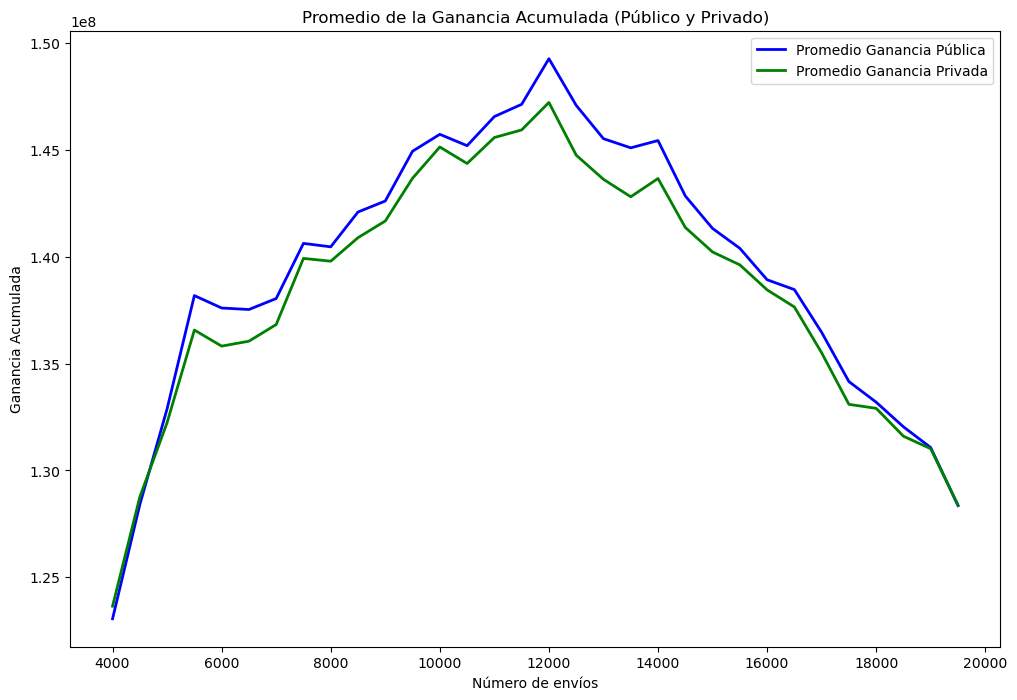

In [ ]:
# Ejecutar la función con 20 repeticiones y graficar solo el promedio
analisis_comportamiento_kaggle_promedios(
    semillas=[],  # Semillas opcionales (puedes pasar una lista o dejarlas vacías para aleatorias)
    desde=4000,
    paso=500,
    cantidad=32,
    private=True,  # Incluir curva privada
    ganancia=ganancia_m1,
    y_pred=y_pred_m1,
    y_etiqueta=y_test_binaria1_m1,
    repeticiones=20,  # Número de repeticiones con distintas semillas
    imprimir_parciales=False  # No imprimir las curvas parciales de cada semilla, solo el promedio final
)

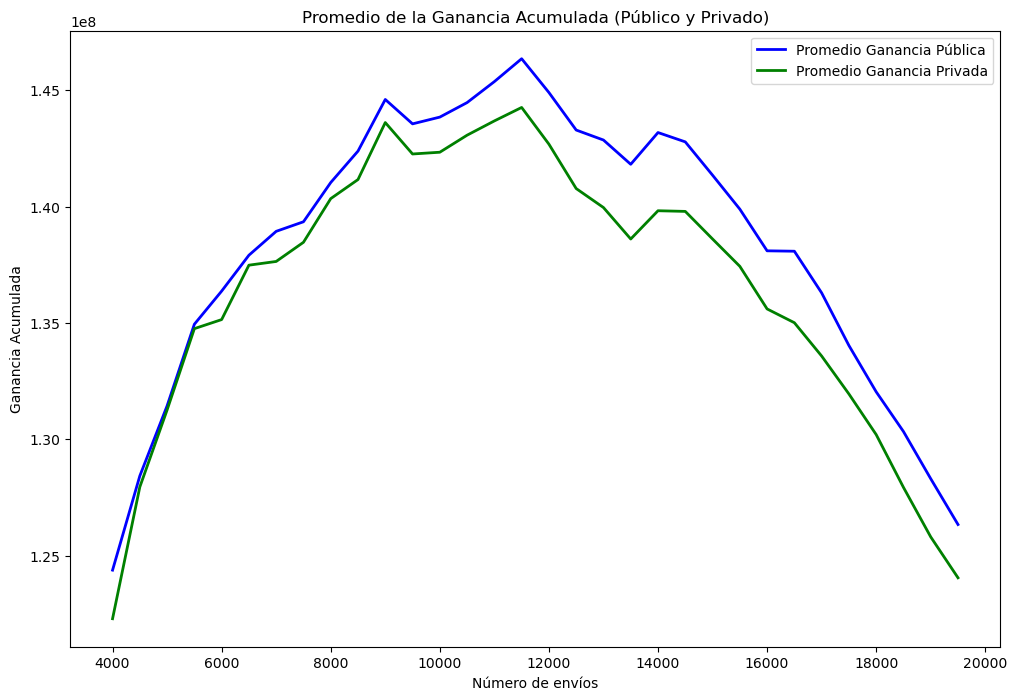

In [32]:
# Ejecutar la función con 20 repeticiones y graficar solo el promedio
analisis_comportamiento_kaggle_promedios(
    semillas=[],  # Semillas opcionales (puedes pasar una lista o dejarlas vacías para aleatorias)
    desde=4000,
    paso=500,
    cantidad=32,
    private=True,  # Incluir curva privada
    ganancia=ganancia_m2,
    y_pred=y_pred_m2,
    y_etiqueta=y_test_binaria1_m2,
    repeticiones=20,  # Número de repeticiones con distintas semillas
    imprimir_parciales=False  # No imprimir las curvas parciales de cada semilla, solo el promedio final
)

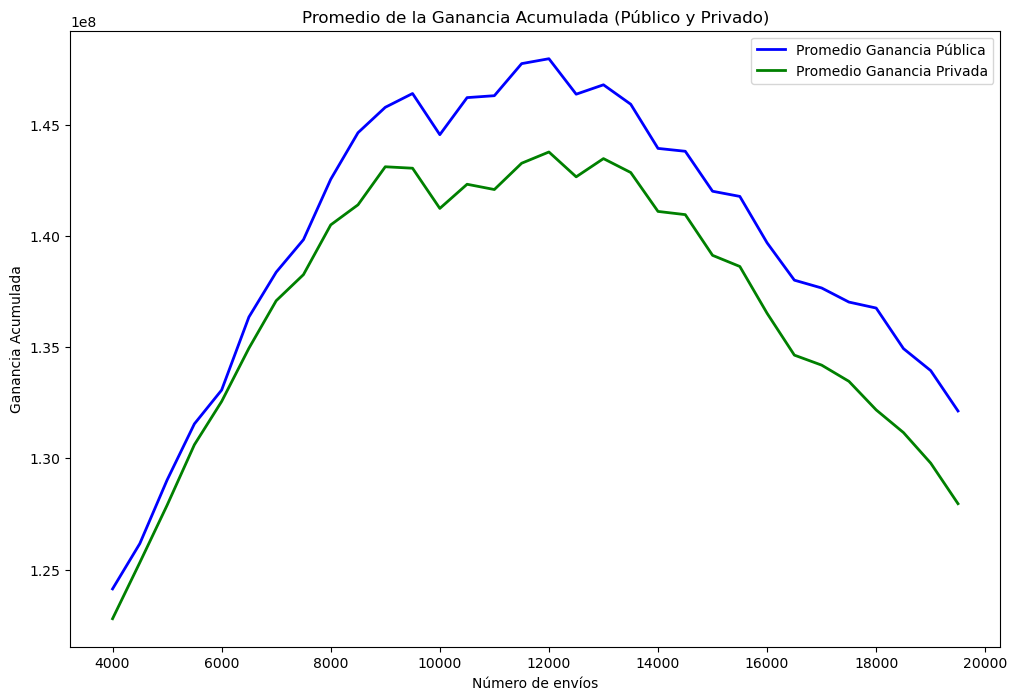

In [33]:
# Ejecutar la función con 20 repeticiones y graficar solo el promedio
analisis_comportamiento_kaggle_promedios(
    semillas=[],  # Semillas opcionales (puedes pasar una lista o dejarlas vacías para aleatorias)
    desde=4000,
    paso=500,
    cantidad=32,
    private=True,  # Incluir curva privada
    ganancia=ganancia_m3,
    y_pred=y_pred_m3,
    y_etiqueta=y_test_binaria1_m3,
    repeticiones=20,  # Número de repeticiones con distintas semillas
    imprimir_parciales=False  # No imprimir las curvas parciales de cada semilla, solo el promedio final
)

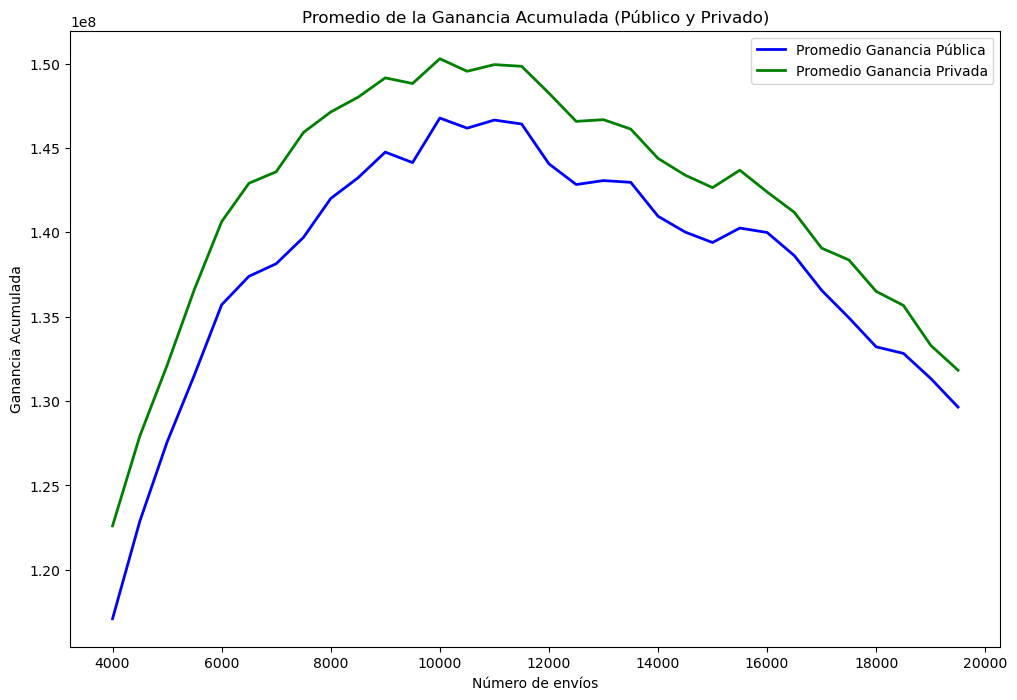

In [47]:
# Ejecutar la función con 20 repeticiones y graficar solo el promedio
analisis_comportamiento_kaggle_promedios(
    semillas=[],  # Semillas opcionales (puedes pasar una lista o dejarlas vacías para aleatorias)
    desde=4000,
    paso=500,
    cantidad=32,
    private=True,  # Incluir curva privada
    ganancia=ganancia_m4,
    y_pred=y_pred_m4,
    y_etiqueta=y_test_binaria1_m4,
    repeticiones=10,  # Número de repeticiones con distintas semillas
    imprimir_parciales=False  # No imprimir las curvas parciales de cada semilla, solo el promedio final
)

In [ ]:
# Una sola semilla, no puedo estar seguro de nada.
# El promedio de dos semillas ya son distribuciones muy parecidas.
# 20 semillas ya son distribuciones iguales.
# 200 semillas distintas ya son la curva iguales.

In [35]:
print("Finalizado")

Finalizado
